In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive



# Import Required Libraries



In [ ]:
import numpy as np
import tensorflow as tf
import librosa
import soundfile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import backend as K
from librosa.util import find_files
from numpy import load
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dropout, LeakyReLU, Conv2DTranspose as Deconv2D, Activation, Concatenate, BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow import keras
import matplotlib.pyplot as plt

# Set Parameters

In [ ]:

SAMPLE_RATE=16000
WINDOW_SIZE=1024
HOP_LENGTH=256

PATCH_SIZE =128 #256
SAMPLE_STRIDE =64
BATCH_SIZE = 14
EPOCH = 100

# Prepare Data
Loading preprocessed Spectrogram of audio dataset.
Splitting the Spectogram into chunks and storing them as a array with shuffling them.

In [ ]:

def prepare_data( chunk_size = 128):
    x_train = []
    y_train = []
    files = find_files('/content/drive/MyDrive/minor_project/Spectrogram3', ext="npz")
    for file in files:
        song = np.load(file)
        num_chunks = song["mix"].shape[1]//chunk_size
        x = song["mix"]
        y = song["vocal"]
        for i in range(num_chunks):
            x_chunk = x[:512, i * chunk_size : (i + 1) * chunk_size, np.newaxis]
            y_chunk = y[:512, i * chunk_size : (i + 1) * chunk_size, np.newaxis]

            x_train.append(x_chunk)
            y_train.append(y_chunk)

    #addding final chunk to data

    final_chunk_x = x[:512,num_chunks*128:,np.newaxis]
    final_chunk_y = y[:512,num_chunks*128:,np.newaxis]
    chunk_length = final_chunk_x.shape[1]

    final_chunk_x = np.pad(final_chunk_x, ((0, 0), (0, 128 - chunk_length), (0, 0)), mode='constant', constant_values=0)
    final_chunk_y = np.pad(final_chunk_y, ((0, 0), (0, 128 - chunk_length), (0, 0)), mode='constant', constant_values=0)
    x_train.append(final_chunk_x)
    y_train.append(final_chunk_y)

    ##till here

    x_train = np.asarray(x_train, dtype = np.float32)
    y_train = np.asarray(y_train, dtype = np.float32)
    return x_train, y_train

#def load_files():
  #npz_files = find_files('/content/drive/MyDrive/minor_project/Spectrogram', ext="npz")
  #return npz_files

#files = load_files()
x_train_initial,y_train_initial = prepare_data()
length  = len(x_train_initial)
print(length)


##shuffling data
x_train = []
y_train = []
no_of_samples = 5000
for i in range(length):
  index = np.random.randint(0,length)
  x_train.append(x_train_initial[index])
  y_train.append(y_train_initial[index])

##till here

x_train = np.asarray(x_train, dtype = np.float32)
y_train = np.asarray(y_train, dtype = np.float32)


#np.savez('/content/drive/MyDrive/minor_project/data_arrays.npz', x_train=x_train[:5000,:,:,:], y_train=y_train[:5000,:,:,:])
#np.savez('/content/drive/MyDrive/minor_project/data_arrays_db.npz', x_train=x_train[:5000,:,:,:], y_train=y_train[:5000,:,:,:])
np.savez('/content/drive/MyDrive/minor_project/data_arrays_shuffled_7k.npz', x_train=x_train, y_train=y_train)
#print(x_train.shape)



7668


# U-Net Model

In [ ]:


def unet(inputs=Input((512, 128, 1))):
    conv1 = Conv2D(16, 5, strides=2, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)

    conv2 = Conv2D(32, 5, strides=2, padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)

    conv3 = Conv2D(64, 5, strides=2, padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.12)(conv3)

    conv4 = Conv2D(128, 5, strides=2, padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)

    conv5 = Conv2D(256, 5, strides=2, padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    conv6 = Conv2D(512, 5, strides=2, padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)

    deconv7 = Deconv2D(256, 5, strides=2, padding='same')(conv6)
    deconv7 = BatchNormalization()(deconv7)
    deconv7 = Dropout(0.5)(deconv7)
    deconv7 = Activation('relu')(deconv7)

    deconv8 = Concatenate(axis=3)([deconv7, conv5])
    deconv8 = Deconv2D(128, 5, strides=2, padding='same')(deconv8)
    deconv8 = BatchNormalization()(deconv8)
    deconv8 = Dropout(0.5)(deconv8)
    deconv8 = Activation('relu')(deconv8)

    deconv9 = Concatenate(axis=3)([deconv8, conv4])
    deconv9 = Deconv2D(64, 5, strides=2, padding='same')(deconv9)
    deconv9 = BatchNormalization()(deconv9)
    deconv9 = Dropout(0.5)(deconv9)
    deconv9 = Activation('relu')(deconv9)

    deconv10 = Concatenate(axis=3)([deconv9, conv3])
    deconv10 = Deconv2D(32, 5, strides=2, padding='same')(deconv10)
    deconv10 = BatchNormalization()(deconv10)
    deconv10 = Activation('relu')(deconv10)

    deconv11 = Concatenate(axis=3)([deconv10, conv2])
    deconv11 = Deconv2D(16, 5, strides=2, padding='same')(deconv11)
    deconv11 = BatchNormalization()(deconv11)
    deconv11 = Activation('relu')(deconv11)

    deconv12 = Concatenate(axis=3)([deconv11, conv1])
    deconv12 = Deconv2D(1, 5, strides=2, padding='same')(deconv12)
    deconv12 = Activation('tanh')(deconv12)

    model = Model(inputs=inputs, outputs=deconv12)
    #model.summary()
    return model

In [ ]:
model = unet()


# Train Model

In [ ]:

# Define MirroredStrategy for training on multiple GPUs
#loaded_data = np.load('/content/drive/MyDrive/minor_project/data_arrays.npz')
loaded_data = np.load('/content/drive/MyDrive/minor/data_arrays_shuffled_7k.npz')
x_train = loaded_data['x_train']
y_train = loaded_data['y_train']

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Create and compile the model within the strategy's scope
    model = unet()
    learning_rate = 0.005
    optimizer = Adam(learning_rate=learning_rate)  #Add gradient clipping here
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=[
                            'accuracy',  # Pixel accuracy
                            #MeanIoU(),  # Dice coefficient
                            #BinaryAccuracy(),  # Pixel accuracy
                            #Recall(),  # Sensitivity
                            #SpecificityAtSensitivity(sensitivity=0.5)  # Specificity
                        ])


# Define a ModelCheckpoint callback to save the best model during training

checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/minor/100model_0.005_14_MSE_val_02.keras',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)


# Train the model using fit method
history =  model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCH,
          verbose=1,
          validation_split=0.2,
          callbacks=[checkpoint_callback]
)



model.save('/content/drive/MyDrive/minor/100model_0.005_14_MSE_val_02.keras')


Epoch 1/100
439/439 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.13115, saving model to /content/drive/MyDrive/minor/100model_0.005_14_MSE_val_02.keras
439/439 [==============================] - 51s 74ms/step - loss: 0.1364 - accuracy: 0.0000e+00 - val_loss: 0.1311 - val_accuracy: 0.0000e+00
Epoch 2/100
438/439 [============================>.] - ETA: 0s - loss: 0.1143 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.13115
439/439 [==============================] - 27s 61ms/step - loss: 0.1143 - accuracy: 0.0000e+00 - val_loss: 0.1427 - val_accuracy: 0.0000e+00
Epoch 3/100
438/439 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 0.13115 to 0.09404, saving model to /content/drive/MyDrive/minor/100model_0.005_14_MSE_val_02.keras
439/439 [==============================] - 27s 63ms/step - loss: 0.0994 - accuracy: 0.0000e+00 - val_loss: 0

In [ ]:
model.save('/content/drive/MyDrive/minor/100model_0.005_14_MSE_val_02.keras')

# Plotting Graph

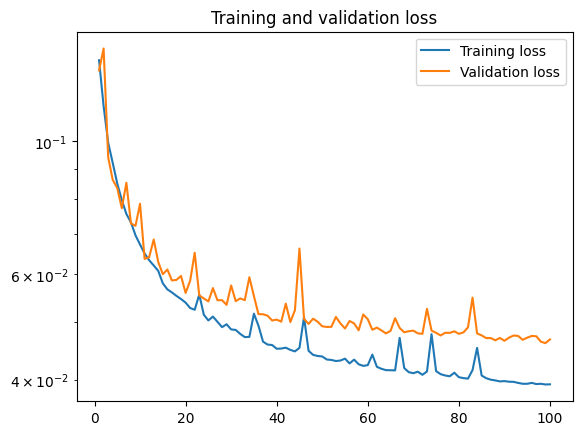

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Load Test Data and Evaluate
Loading the test dataset from spectrogram after preprocessing it

In [ ]:
def prepare_test_data( chunk_size = 128):
    x_train = []
    y_train = []
    files = find_files('/content/drive/MyDrive/minor/SpectrogramTEST', ext="npz")
    for file in files:
        song = np.load(file)
        num_chunks = song["mix"].shape[1]//chunk_size
        x = song["mix"]
        y = song["vocal"]
        for i in range(num_chunks):
            x_chunk = x[:512, i * chunk_size : (i + 1) * chunk_size, np.newaxis]
            y_chunk = y[:512, i * chunk_size : (i + 1) * chunk_size, np.newaxis]

            x_train.append(x_chunk)
            y_train.append(y_chunk)


    x_train = np.asarray(x_train, dtype = np.float32)
    y_train = np.asarray(y_train, dtype = np.float32)
    return x_train, y_train

x_test, y_test = prepare_test_data()
print(x_test.shape)

(4445, 512, 128, 1)


In [ ]:
x_test = np.asarray(x_test, dtype = np.float32)
y_test = np.asarray(y_test, dtype = np.float32)
np.savez('/content/drive/MyDrive/minor/test_arrays.npz', x_train=x_train, y_train=y_train)

In [ ]:
trained_model = keras.models.load_model('/content/drive/MyDrive/minor/first_model_0_005.keras')
test_data = np.load('/content/drive/MyDrive/minor/test_arrays.npz')
x_test = test_data['x_train']
y_test = test_data['y_train']

# Evaluate the model on the test data
evaluation_results = trained_model.evaluate(x_test, y_test)

print("Evaluation Results:")
print("Loss:", evaluation_results)

#or i, metric_name in enumerate(model.metrics_names):
    #print(f"{metric_name}: {evaluation_results[i + 1]}")

In [ ]:
print(tf.__version__)
!pip install museval

2.15.0


In [ ]:
import numpy as np
import museval


separated_vocals_path = '/content/drive/MyDrive/minor/output_mixture_NSfull.wav'
ground_truth_vocals_path = '/content/drive/MyDrive/minor/vocals.wav'

# Load the separated and ground truth vocal audio files
separated_vocals, _ = librosa.load(separated_vocals_path, sr=None)
ground_truth_vocals, _ = librosa.load(ground_truth_vocals_path, sr=None)

# Normalize the audio signals to the range [-1, 1]
separated_vocals = separated_vocals.astype(np.float32) / np.max(np.abs(separated_vocals))
ground_truth_vocals = ground_truth_vocals.astype(np.float32) / np.max(np.abs(ground_truth_vocals))
min_length = min(len(separated_vocals), len(ground_truth_vocals))
#min_length = min(len(separated_vocals), len(ground_truth_vocals))
separated_vocals = separated_vocals[:min_length]
ground_truth_vocals = ground_truth_vocals[:min_length]

# Compute the SDR, SIR, SAR, and ISR metrics
scores = museval.evaluate(
    references=[ground_truth_vocals],
    estimates=[separated_vocals],
    win=min_length,  # Set window size to the length of the signals
)
SDR = scores[0][0][0]
SIR = scores[1][0][0]
SAR = scores[2][0][0]
ISR = scores[3][0][0]

# Print the scores higher indicates better separation quality. I
print("SDR:", SDR)
print("SIR:", SIR)
print("SAR:", SAR)
print("ISR:", ISR)

#Predict and Isolate Vocals


In [ ]:
import tensorflow as tf
from tensorflow import keras
import librosa
import numpy as np
import soundfile



trained_model = keras.models.load_model('/content/drive/MyDrive/minor/first_model_0_005.keras')



def LoadAudio(file_path) :
    WINDOW_SIZE=1024
    HOP_LENGTH=256
    SR =  16000

    y, sr = librosa.load(file_path,sr=SR)

    stft = librosa.stft(y,n_fft=WINDOW_SIZE,hop_length=HOP_LENGTH)

    mag, phase = librosa.magphase(stft)
    mag = mag**2
    mag = librosa.power_to_db(mag)


    mag = mag.astype(np.float32)


    norm = mag.max()
    mag /= norm








    return mag, phase, norm

test_song_mag, test_song_phase, norm = LoadAudio('/content/drive/MyDrive/minor/songs/redhot.wav')


x_test = []
num_chunks = test_song_mag.shape[1]//128
for i in range(num_chunks):
    chunk = test_song_mag[:512, i * 128 : (i + 1) * 128, np.newaxis]
    x_test.append(chunk)

x_test = np.asarray(x_test, dtype = np.float32)
y_test = trained_model.predict(x_test)
print("max prediction")
print(y_test.max())


reconstructed_song =  np.zeros((512, 128*len(y_test), 1))
for i, chunk in enumerate(y_test):
    reconstructed_song[:, i * 128:(i + 1) * 128, :] = chunk



reconstructed_song = np.squeeze(reconstructed_song, axis=-1)


reconstructed_song = reconstructed_song*norm


reconstructed_song =  reconstructed_song.astype(np.float32)
reconstructed_song = librosa.db_to_power(reconstructed_song)
reconstructed_song = reconstructed_song ** 0.5








test_song_phase = test_song_phase[:512,:128*len(x_test)]
test_song_angle = np.angle(test_song_phase)

spectrum = reconstructed_song * np.exp(1j*test_song_phase)



final_audio = librosa.istft(spectrum)



SR =  16000

soundfile.write("/content/drive/MyDrive/minor_project/songs/output_song_db.wav", final_audio, SR)


1/1 [==============================] - 1s 976ms/step
max prediction
0.7969082
spectrum final
(512, 1792)
<class 'numpy.complex64'>
audio final
(456705,)
<class 'numpy.float32'>


In [ ]:
import IPython.display as ipd
audio_path = "/content/drive/MyDrive/minor_project/songs/redhot.wav"
ipd.Audio(audio_path,rate=16000)

In [ ]:
import IPython.display as ipd
audio_path = "/content/drive/MyDrive/minor_project/songs/output_song_db.wav"
ipd.Audio(audio_path,rate=16000)